In [1]:
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Calculating the X-ray Spectrum

In [2]:
rmf = fits.open('data/pspcb_gain2_256.rmf')
arf = fits.open('data/pspcb_gain2_256.arf')

kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

rosat_spectrum = pyatomdb.spectrum.CIESession()
rosat_spectrum.set_response(rmf, arf)
rosat_spectrum.set_abund(26,0.3)

J_tot = rosat_spectrum.return_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)
J_cont = rosat_spectrum.return_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                              dolines=False, dopseudo=False)

## Producing the profiles

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(mdef=mdef)

a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1e14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

# Battaglia

dens_bg = rx.HaloProfileDensityBattaglia(kind='n_total')
density_bg = dens_bg.real(cosmo, r, M, a, mdef)
pres_bg = rx.HaloProfilePressureBattaglia(kind='P_total')
pressure_bg = pres_bg.real(cosmo, r, M, a, mdef)

tot_bg = rx.HaloProfileXray(J_tot, dens=dens_bg, pres=pres_bg)
cont_bg = rx.HaloProfileXray(J_cont, dens=dens_bg, pres=pres_bg)
xtot_bg = tot_bg.real(cosmo, r, M, a, mdef)
xcont_bg = cont_bg.real(cosmo, r, M, a, mdef)


# Hydrostatic Equilibirum

dens_he = rx.HaloProfileDensityHydrostaticEquilibriumTempera(kind='n_total')
density_he = dens_he.real(cosmo, r, M, a, mdef)
temp_he = rx.HaloProfileTemperatureHydrostaticEquilibrium(kind='T_total')
temperature_he = temp_he.real(cosmo, r, M, a, mdef)

tot_he = rx.HaloProfileXray(J_tot, dens=dens_he, temp=temp_he)
cont_he = rx.HaloProfileXray(J_cont, dens=dens_he, temp=temp_he)
xtot_he = tot_he.real(cosmo, r, M, a, mdef)
xcont_he = cont_he.real(cosmo, r, M, a, mdef)


# NFW

dens_nfw = rx.HaloProfileDensityNFW(cM, kind='n_total')
density_nfw = dens_nfw.real(cosmo, r, M, a, mdef)
temp_sl = rx.HaloProfileTemperatureSpectroscopicLike()
temperature_nfw = temp_sl.real(cosmo, r, M, a, mdef)

tot_nfw = rx.HaloProfileXray(J_tot, dens=dens_nfw, temp=temp_sl)
cont_nfw = rx.HaloProfileXray(J_cont, dens=dens_nfw, temp=temp_sl)
xtot_nfw = tot_nfw.real(cosmo, r, M, a, mdef)
xcont_nfw = cont_nfw.real(cosmo, r, M, a, mdef)

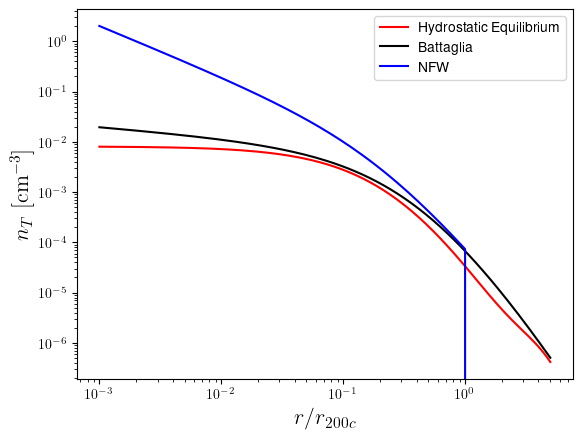

In [4]:
plt.plot(x, density_he, 'r', label="Hydrostatic Equilibrium")
plt.plot(x, density_bg, 'k', label="Battaglia")
plt.plot(x, density_nfw, 'b', label="NFW")
plt.ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
plt.xlabel(r'$r/r_{200c}$', fontsize=16)
plt.loglog()
plt.legend();

/var/folders/fs/v_j86wls4cx1xxnw5lmt71m4000txz/T/ipykernel_91925/3863542596.py:24: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(x, xtot_nfw/density_nfw**2, 'b-')
/var/folders/fs/v_j86wls4cx1xxnw5lmt71m4000txz/T/ipykernel_91925/3863542596.py:25: RuntimeWarning: invalid value encountered in divide
  ax[3].plot(x, xcont_nfw/density_nfw**2, 'b--')


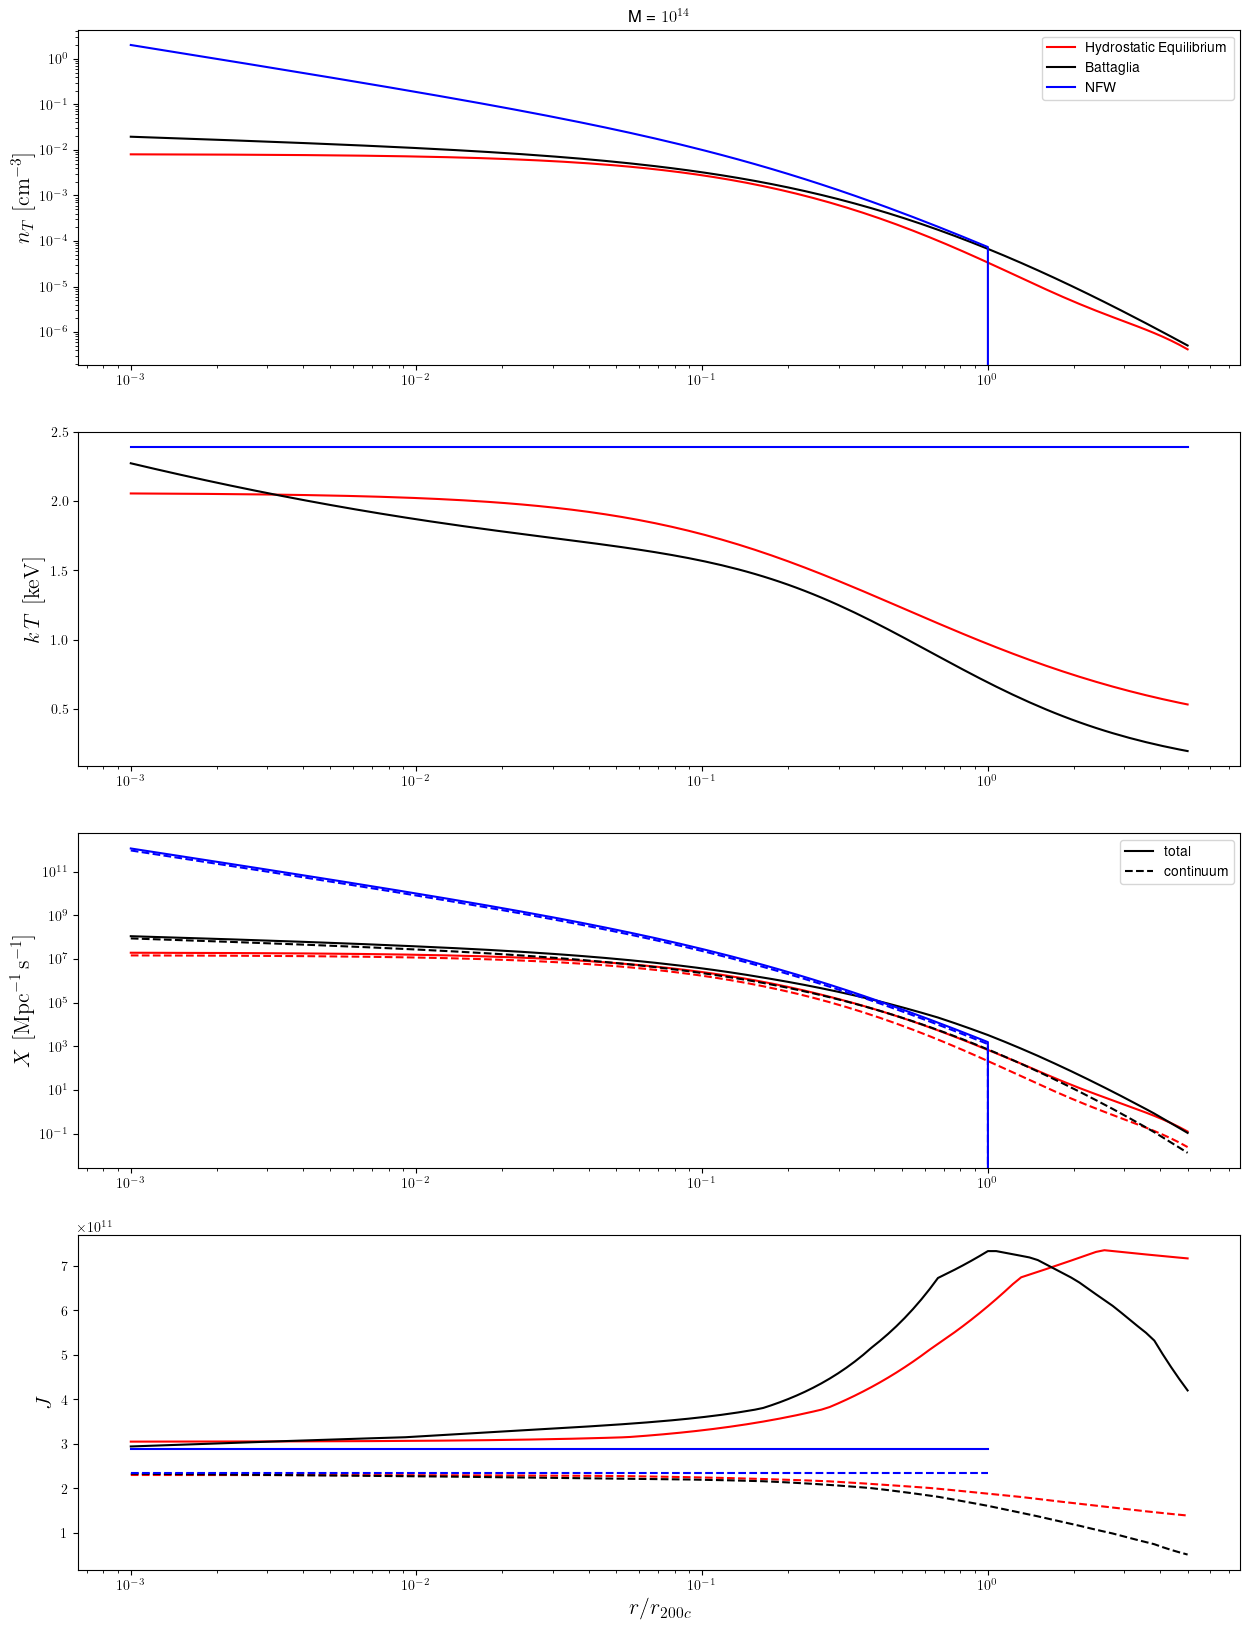

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(15, 20))
    
ax[0].plot(x, density_he, 'r', label='Hydrostatic Equilibrium')
ax[0].plot(x, density_bg, 'k', label='Battaglia')
ax[0].plot(x, density_nfw, 'b', label='NFW')
ax[0].legend()

ax[1].plot(x, 1e-3*temperature_he, 'r')
ax[1].plot(x, 1e-3*pressure_bg/density_bg, 'k')
ax[1].plot(x, 1e-3*temperature_nfw, 'b')

ax[2].plot(x, xtot_he, 'r-')
ax[2].plot(x, xcont_he, 'r--')
ax[2].plot(x, xtot_bg, 'k-', label='total')
ax[2].plot(x, xcont_bg, 'k--', label='continuum')
ax[2].plot(x, xtot_nfw, 'b-')
ax[2].plot(x, xcont_nfw, 'b--')
ax[2].legend()

ax[3].plot(x, xtot_he/density_he**2, 'r-')
ax[3].plot(x, xcont_he/density_he**2, 'r--')
ax[3].plot(x, xtot_bg/density_bg**2, 'k-')
ax[3].plot(x, xcont_bg/density_bg**2, 'k--')
ax[3].plot(x, xtot_nfw/density_nfw**2, 'b-')
ax[3].plot(x, xcont_nfw/density_nfw**2, 'b--')

#ax[0].loglog()
#ax[1].loglog()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xscale('log')
    
ax[0].set_ylabel(r'$n_T\,\,[{\rm cm}^{-3}]$', fontsize=16)
ax[1].set_ylabel(r'$k\,T\,\,[{\rm keV}]$', fontsize=16)
ax[2].set_ylabel(r'$X\,\,[{\rm Mpc}^{-1}\,{\rm s}^{-1}]$', fontsize=16)
ax[3].set_ylabel(r'$J$', fontsize=16)

ax[3].set_xlabel(r'$r/r_{200c}$', fontsize=16)

ax[0].set_title('M = $10^{14}$');

fig.savefig('Plots/Profiles_comparison.pdf')